In [2]:
# load some packages
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np


In [6]:
# load galaxy catalogue
catalogue = np.load("catalogue_1000sqd.npy", allow_pickle=True)
# catalogue = np.load("catalogue.npy", allow_pickle=True)

the galaxy catalogue is entirely in one pixel for a map of nside 64

# useful healpy functions:
documentation can be found here: https://healpy.readthedocs.io/en/latest/
- `npix = hp.nside2npix(nside)` -> total number of pixels
- `resol = hp.nside2resol(nside, arcmin=True)` -> resolution of the pixels in arcminutes
- `i = hp.ang2pix(nside, theta, phi,lonlat=True)` -> pixel number for a given theta and phi, theta and phi in degree (by lonlat=True). The respective pixel can then simply be selected by map[i].
- `hp.cartview(lonra=[lon_center-lon_range / 2, lon_center+lon_range/2], latra=[lat_center-lat_range/2, lat_center+lat_range/2], )` -> plots a flact rectangular projection of a part of a map given by lonra and latra
- `hp.mollview(map)` -> plots full sky projection of a spherical map

In [7]:
print(hp.nside2resol(64, arcmin=True))


54.967782589078496


In [ ]:
names = catalogue.dtype.names
catalogue['gamma1']
print(names)

array([ 17.730425,  17.776804,  17.72555 , ..., -17.77829 , -17.728695,
       -17.792723], shape=(31574550,), dtype=float32)

[ 0.10386734 -0.02873604 -0.12311932 ... -0.23293167 -0.47333738
 -0.31704372] [ 17.730425  17.776804  17.72555  ... -17.77829  -17.728695 -17.792723]


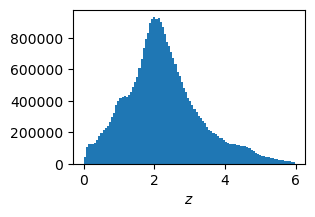

In [11]:
# catalogue properties can be accessed like this, e.g. the right ascension and declination:
print(catalogue['ra'],catalogue['dec'])
# or the redshifts:
plt.figure(figsize=(3,2))
plt.hist(catalogue['z'], bins=100)
plt.xlabel("$z$")
plt.show()


the sizes we are mainly interested in are given in pixels on the sky. For different surveys, one pixel corresponds to a different angular resolution (like the telescope resolution and the CCD resolution you also had to take into account for Astrowoche).
For this simulation, one pixel corresponds to 0.263 arcseconds (corresponding to $1/3600$ degree)

In [12]:
pixscale = 0.263
sizes_in_arcsec = catalogue['r50'] * pixscale   # arcsec
print(sizes_in_arcsec)

[0.14015451 0.3006854  1.7140671  ... 0.48972714 0.3066714  0.29039302]


Now we plot a selection of galaxies for visualization. They are at different distances (still a range of redshifts) and also have different intrinsic sizes such that the bunch of them follows some size distribution, let's call it $s(\theta) \ \mathrm{d} \theta$ that we for now assume to be independent of location.

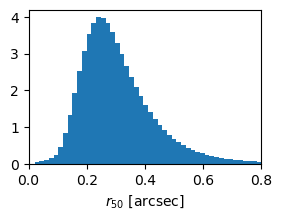

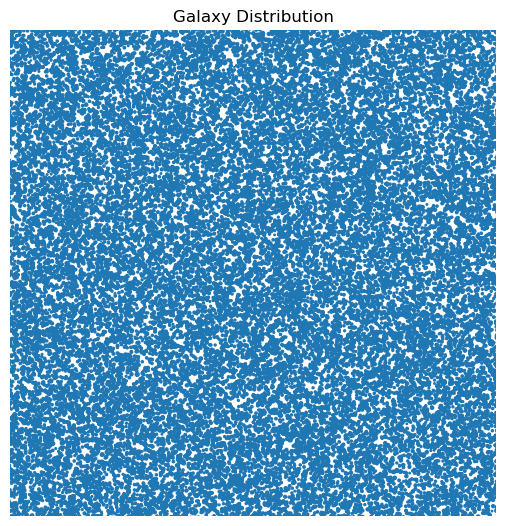

In [13]:
# this would be s(\theta):
plt.figure(figsize=(3,2))
plt.hist(sizes_in_arcsec, bins=3000,density=True)
plt.xlim(0,.8)
plt.xlabel("$r_{50}$ [arcsec]")
plt.show()

lon_center = np.mean(catalogue['ra'])
lat_center = np.mean(catalogue['dec'])
lon_range = 1 # plotting range in degrees
lat_range = 1

hp.cartview(lonra=[lon_center-lon_range / 2, lon_center+lon_range/2], latra=[lat_center-lat_range/2, lat_center+lat_range/2], title="Galaxy Distribution", cbar=False)
hp.projscatter(catalogue['ra'],catalogue['dec'], s=10*sizes_in_arcsec,lonlat=True)
plt.show()



We now load the 2D powerspectrum for the convergence $\kappa$, plot it and then use `hp.synfast(cl_kappa,nside=256)` to generate a convergence map. These are the predicted values of the integrated dark matter density along each line of sight, given a cosmological model. For now, they are Gaussian distributed with a given covariance structure that depends on the distance to each other. The further two points on the map are apart, the lower the correlation or covariance between the two kappa values (i.e. the closer to complete independence they are). This can also be seen when looking at the power spectrum: the $\ell \propto \frac{1}{\vartheta}$ where the power spectrum peak corresponds to the size scale $\vartheta$ where the correlation is the strongest. This is the characteristic size scale on which dark matter clumps together.

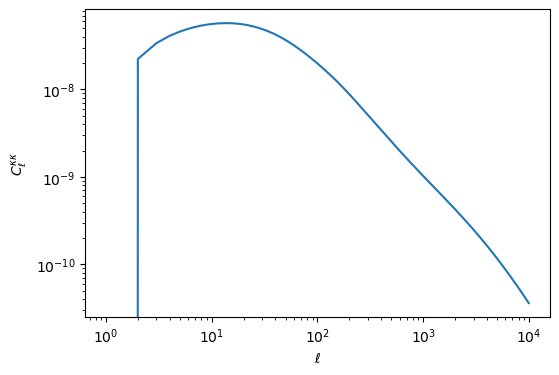

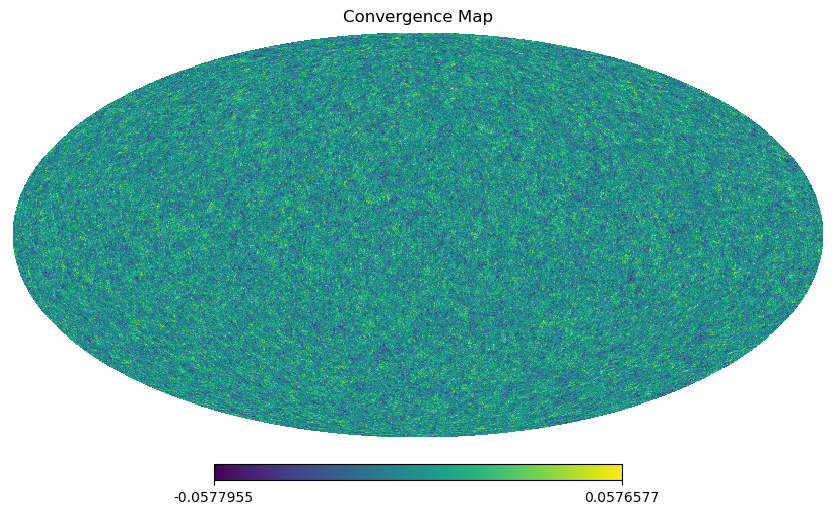

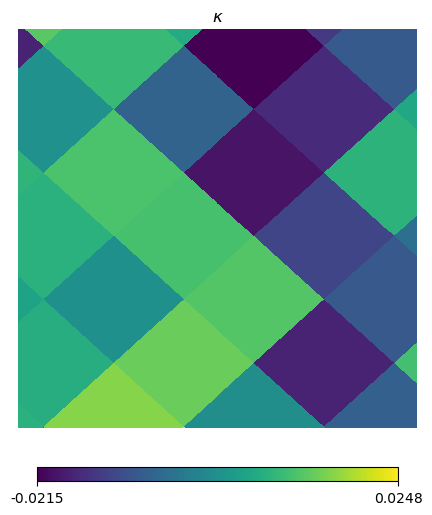

In [18]:
# cl_kappa = np.loadtxt("cl_kappa.txt") 
cl_kappa = np.loadtxt("cl_kappa_mean_225.txt")

cl_kappa = np.concatenate((np.zeros(2), cl_kappa[:,1])) # add zeros for monopole and dipole
plt.figure(figsize=(6,4))
plt.plot(cl_kappa)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\ell$")
plt.ylabel("$C_{\ell}^{\kappa\kappa}$")
plt.show()
kappamap = hp.synfast(cl_kappa, 256) # generate a convergence map
hp.mollview(kappamap, title="Convergence Map", cbar=True) # plot it
hp.cartview(kappamap,lonra=[lon_center-10-lon_range/2, lon_center-10+lon_range/2], latra=[lat_center-20-lat_range/2, lat_center-20+lat_range/2], title='$\kappa$', cbar=True) # plot a subregion corresponding to size of galaxy distribution seen earlier


we already see that the range of $\kappa$ values is smaller in this subfield and that several galaxies are covered by the same value. This is also theoretically true, not only because we generated the map like this - the correlation length of the convergence (the peak of the power spectrum) is much larger than the average distance of galaxies because the large scale dark matter structure operates on much larger scales than single galaxies. 